In [186]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
import statsmodels.tsa.api as smt

from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [99]:
stock = pd.read_csv("AppleCompanyStock.csv")

In [100]:
stock.head()

,year,month,open,high,low,close,volume
0,2018,3,177.32,177.470,173.66,175.82,46812368
1,2018,3,180.29,183.500,177.62,178.02,151720299
2,2018,3,175.21,180.000,174.27,179.98,138442235
3,2018,3,176.35,180.615,172.45,176.21,196432091
4,2018,2,172.05,175.650,171.01,175.50,133197874


In [101]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    950 non-null    int64  
 1   month   950 non-null    int64  
 2   open    950 non-null    float64
 3   high    950 non-null    float64
 4   low     950 non-null    float64
 5   close   950 non-null    float64
 6   volume  950 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 52.1 KB


In [102]:
stock.describe()

,year,month,open,high,low,close,volume
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,9.500000e+02
mean,2008.631579,6.497895,168.952003,174.218120,164.176523,169.350997,1.092915e+08
std,5.259449,3.463112,167.253584,171.648176,163.694731,167.548177,8.144325e+07
min,2000.000000,1.000000,13.130000,13.630000,12.720000,13.120000,5.515100e+06
25%,2004.000000,3.000000,46.232500,48.335000,44.840000,46.130000,4.347195e+07
50%,2009.000000,6.500000,111.405000,114.735000,108.230000,111.940000,9.234840e+07
75%,2013.000000,9.750000,195.610000,202.487500,190.272500,195.240000,1.511180e+08
max,2018.000000,12.000000,699.350000,705.070000,693.620000,700.095000,5.003630e+08


## Exploratory Data Analysis (EDA)

In [103]:
stock = stock.loc[:,["year", "month", "close", "volume"]]
stock.head()

,year,month,close,volume
0,2018,3,175.82,46812368
1,2018,3,178.02,151720299
2,2018,3,179.98,138442235
3,2018,3,176.21,196432091
4,2018,2,175.50,133197874


#### Take the last closing price and vloume for each month

Before we start to analyse our data we need a single data point for each month and year. We will use the **last** value for each month for doing so. 
The reason we are not averaging it out is because we can loose important information that way. 


In [104]:
stock_agg = stock.groupby(["year","month"]).tail(1)
stock_agg.head()

,year,month,close,volume
3,2018,3,176.21,196432091
7,2018,2,160.50,248091289
11,2018,1,175.00,99095223
16,2017,12,171.05,166555527
20,2017,11,172.50,203892677


In [105]:
stock_agg = stock_agg.sort_values(by=["year", "month"],ascending=True).reset_index()
stock_agg.drop(axis=1,columns='index',inplace=True)
stock_agg.head()

,year,month,close,volume
0,2000,1,100.44,29872700
1,2000,2,108.00,21289500
2,2000,3,128.00,21508200
3,2000,4,131.75,17398400
4,2000,5,113.12,14607300


##### Creating the year-month combined feature for plotting

In [106]:
stock_agg["yrmo"] = stock_agg["year"].map(str)+stock_agg["month"].map(str)

In [107]:
stock_agg.head()

,year,month,close,volume,yrmo
0,2000,1,100.44,29872700,20001
1,2000,2,108.00,21289500,20002
2,2000,3,128.00,21508200,20003
3,2000,4,131.75,17398400,20004
4,2000,5,113.12,14607300,20005


#### Plot the closing price vs time

In [108]:
def get_scatterplot(stock,yvar,ylim):
    fig = plt.figure(figsize=(20,14))
    for i,p in zip(range(4), range(0,220, 55)):
        plt.subplot(221+i)
        plt.xticks(rotation=90)
        ax = sns.lineplot(x="yrmo", y=yvar,data=stock[p:p+55], sort=False)
        plt.xlabel("Year-Month")
        ax.set_ylim(ylim)

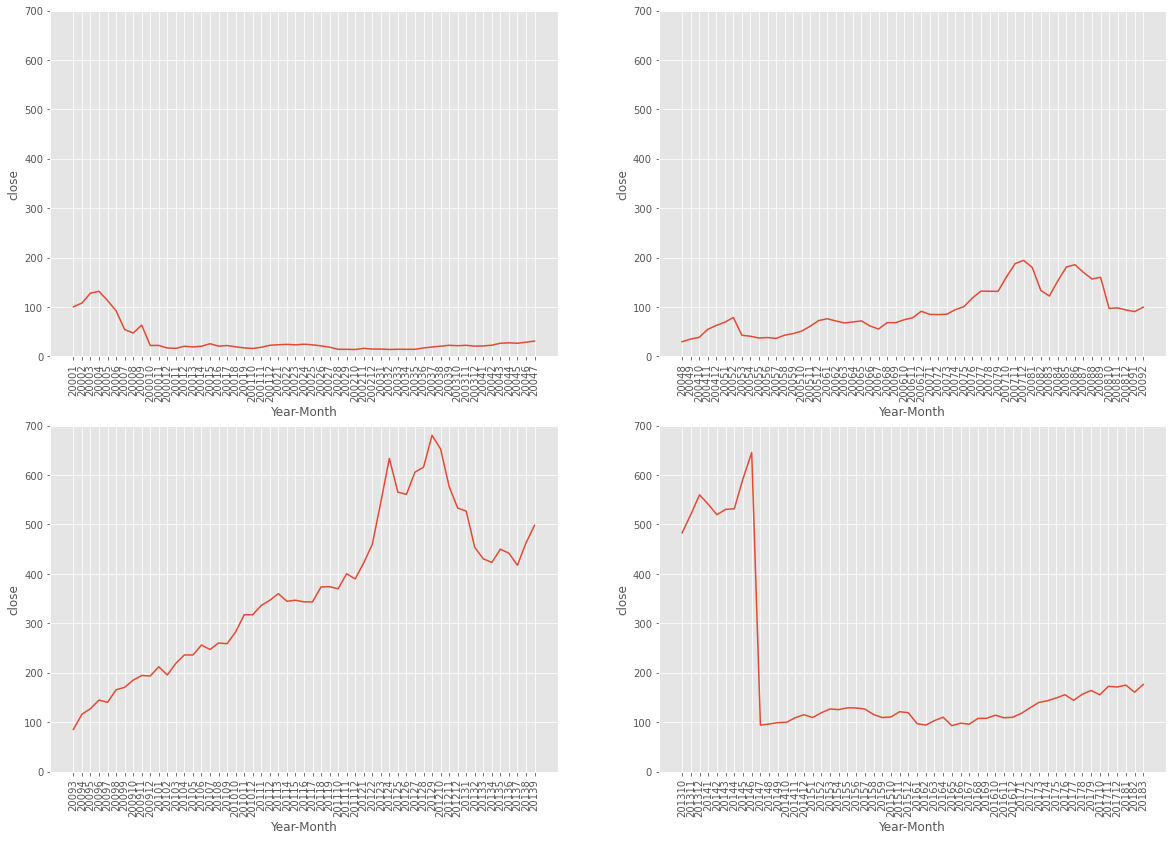

In [109]:
get_scatterplot(stock_agg,"close",[0,700])

- Iphone 3gs and macbook pro came out around May-June 2009 when the stock price rose meteorically.
- In June 2014 there was split in apple stock in ratio of 1:7 so each share was divided into 7 shares of equal value.

### Split Adjusted Stock Price

##### Stock price upto June 2014 needs to be divided by 7 in order to determine the split adjusted price and bring all values to same scale.

In [110]:
idx = stock_agg.index[(stock_agg.year==2014) & (stock_agg.month==6)].tolist()[0]

In [111]:
sad = stock_agg.loc[0:idx,'close']/7
sad = sad.append(stock_agg.loc[idx+1:len(stock_agg),'close'])

In [112]:
stock_agg['close'] = sad

In [113]:
stock_agg[(stock_agg.year<=2014)].tail(10)

,year,month,close,volume,yrmo
170,2014,3,75.777143,39435800,20143
171,2014,4,75.974286,35265900,20144
172,2014,5,84.654286,67823800,20145
173,2014,6,92.224286,58974500,20146
174,2014,7,94.030000,139168800,20147
175,2014,8,96.130000,236825000,20148
176,2014,9,98.970000,322672500,20149
177,2014,10,99.620000,247749150,201410
178,2014,11,109.010000,199952812,201411
179,2014,12,115.000000,266701088,201412


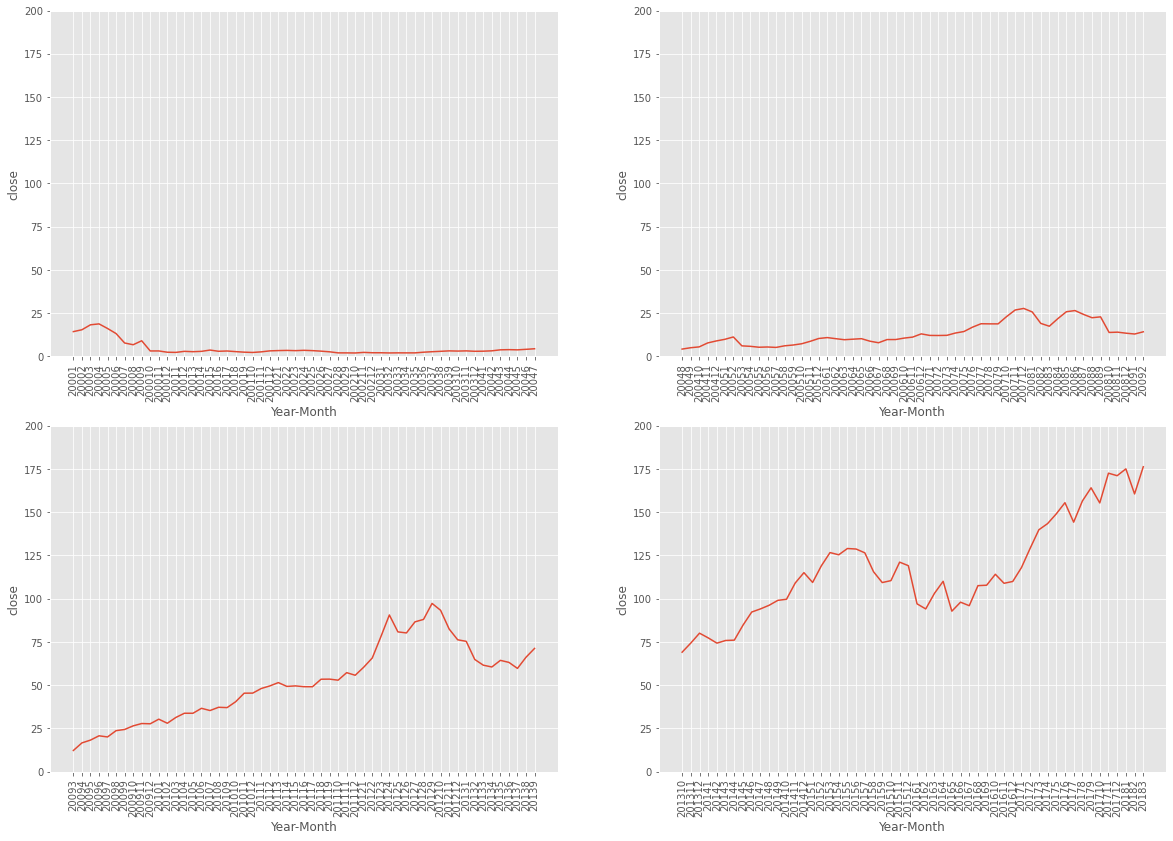

In [114]:
get_scatterplot(stock_agg,"close", [0,200])

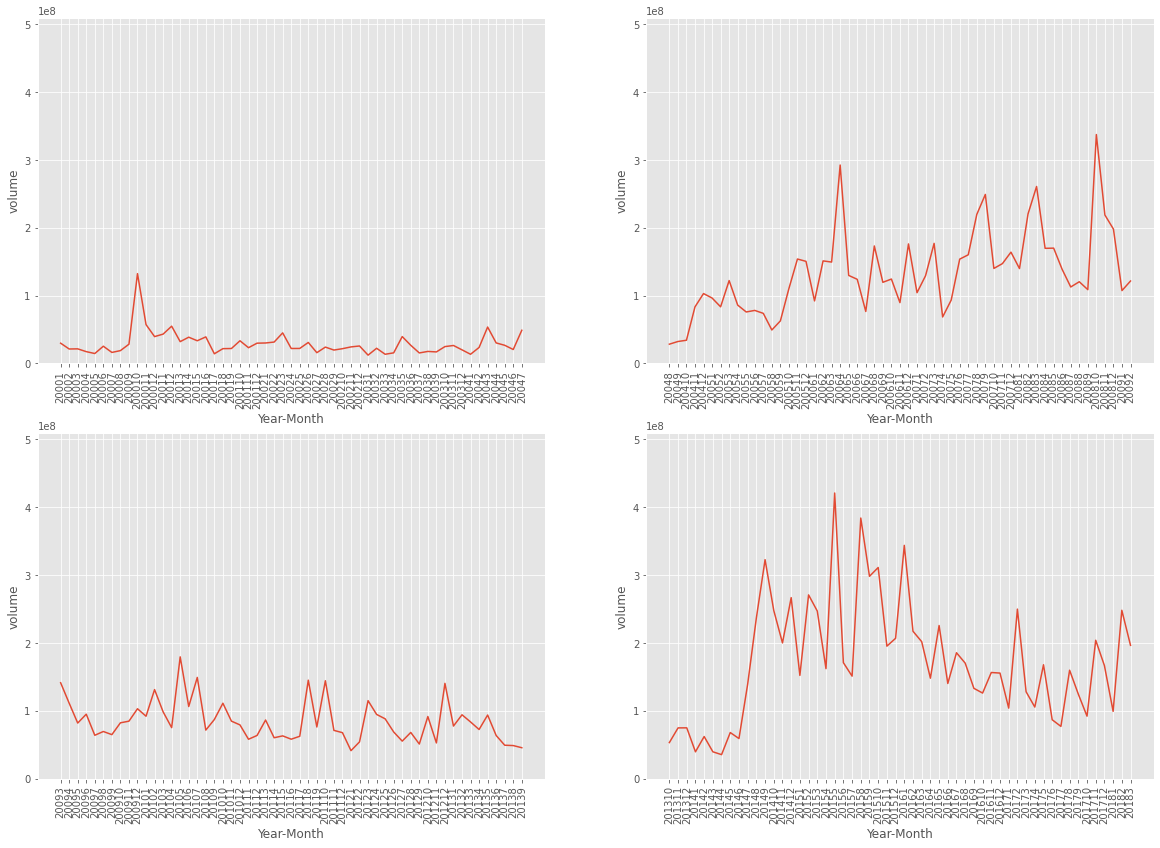

In [115]:
get_scatterplot(stock_agg,"volume",[0,510000000])

### Split Adjusted Volume

In [116]:
sav = stock_agg.loc[0:idx,'volume']*7
sav = sav.append(stock_agg.loc[idx+1:len(stock_agg),'volume'])

In [117]:
stock_agg['volume'] = sav

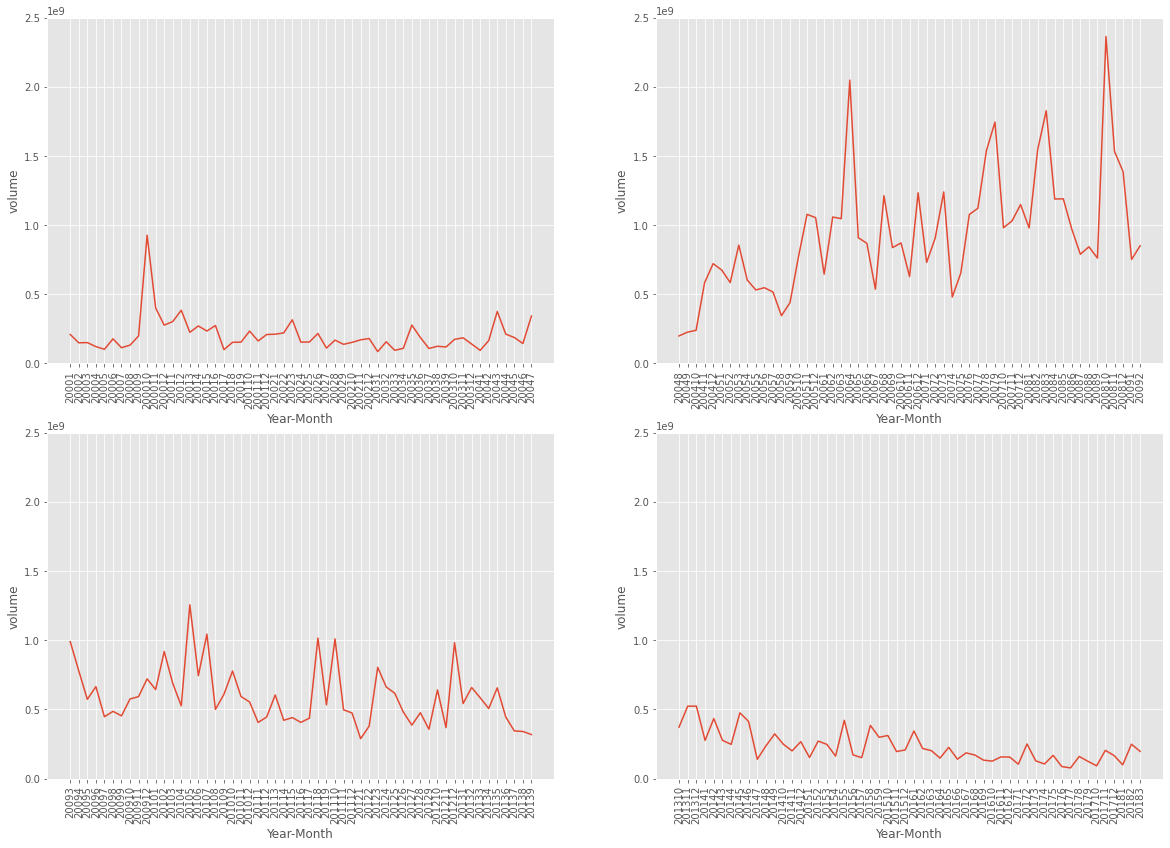

In [118]:
get_scatterplot(stock_agg,"volume",[0,2500000000])

- If we see **2008 October** there is a large surge in volume which corresponds to a huge sell off of apple stock and corresponding fall in the price. This implies a negative correlation between volume and closing price. Let's confirm this with the correlation heatmap.

## Correlation Heatmap

In [119]:
corr = stock_agg[["close","volume"]].corr()

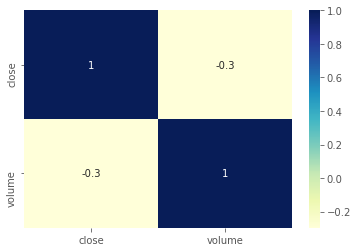

In [120]:
sns.heatmap(corr, annot=True, cmap="YlGnBu")

## Lags, Moving Average and RSI based Features

- Moving average is the average price of the stock over past n time periods. It indicates movement of the stock and smoothens the price changes.


- RSI relative strength indicator is the indicator of the fact that whether the stock is oversold or overbought.


- If the RSI is near 0 that means that the stock is over sold and is likely to rebound from its recent lows.


- if the RSI is near 100 it means that the stock is over bought and is likely to reverse to a downward trajectory.

In [121]:
for i in range(1,7):
    stock_agg['close_lag' + str(i)] = stock_agg['close'].shift(i)

In [122]:
stock_agg.head()

,year,month,close,volume,yrmo,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6
0,2000,1,14.348571,209108900,20001,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,15.428571,149026500,20002,14.348571,NaN,NaN,NaN,NaN,NaN
2,2000,3,18.285714,150557400,20003,15.428571,14.348571,NaN,NaN,NaN,NaN
3,2000,4,18.821429,121788800,20004,18.285714,15.428571,14.348571,NaN,NaN,NaN
4,2000,5,16.160000,102251100,20005,18.821429,18.285714,15.428571,14.348571,NaN,NaN


Formula for RS = average gain over n periods/average loss over n periods

RSI = 100 - (100/(1 + RS))

In [123]:
# talib is not working so use the following instead:
# import talib
# for n in [3,6,9,12]:
# 
#     # Create the moving average and divide by the close price to average it out
#     stock_agg['ma_' + str(n)] = talib.SMA(stock_agg['close'].values,
#                               timeperiod=n) / stock_agg['close']
#     # Create the RSI indicator
#     stock_agg['rsi_' + str(n)] = talib.RSI(stock_agg['close'].values, timeperiod=n)
# stock_agg.head(10)

In [124]:
def rsiFunc(prices, n):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100 - 100/(1+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100 - 100/(1+rs)

    return rsi

In [125]:
for n in [3,6, 9, 12]:
    # Create the moving average and divide by the close price to average it out
    #SMA simple moving average
    stock_agg['ma_ ' + str(n)]    = stock_agg['close'].rolling(window=n).mean() / stock_agg['close']  #divuide by close for normalization
    stock_agg['rsi_' + str(n)] = rsiFunc(stock_agg['close'], n)

In [126]:
print(stock_agg.head(20))

    year  month      close     volume    yrmo  close_lag1  close_lag2  \
0   2000      1  14.348571  209108900   20001         NaN         NaN   
1   2000      2  15.428571  149026500   20002   14.348571         NaN   
2   2000      3  18.285714  150557400   20003   15.428571   14.348571   
3   2000      4  18.821429  121788800   20004   18.285714   15.428571   
4   2000      5  16.160000  102251100   20005   18.821429   18.285714   
5   2000      6  13.222857  177703400   20006   16.160000   18.821429   
6   2000      7   7.777143  113649200   20007   13.222857   16.160000   
7   2000      8   6.768571  132244700   20008    7.777143   13.222857   
8   2000      9   9.062857  198487100   20009    6.768571    7.777143   
9   2000     10   3.170000  926824500  200010    9.062857    6.768571   
10  2000     11   3.178571  400869000  200011    3.170000    9.062857   
11  2000     12   2.437143  276921400  200012    3.178571    3.170000   
12  2001      1   2.338571  302642200   20011    2.

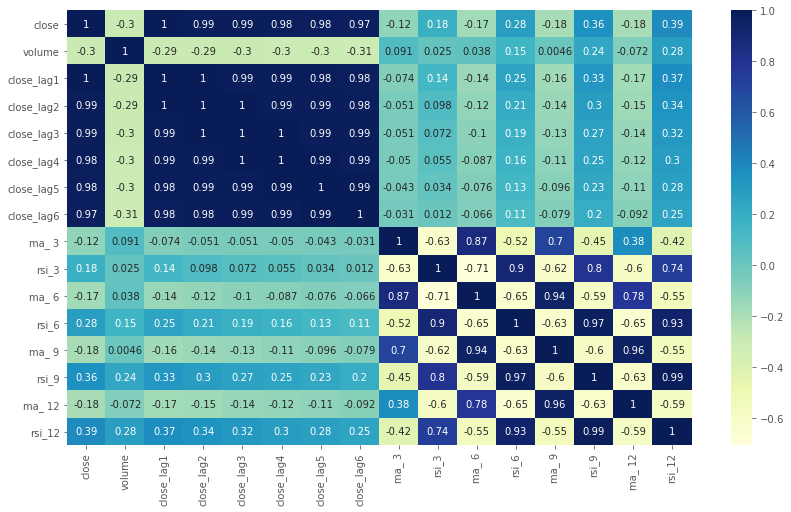

In [127]:
plt.figure(figsize=(14,8))
corr = stock_agg.drop(columns=["year","month","yrmo"]).corr()
sns.heatmap(data=corr, annot=True, cmap="YlGnBu")

# Data Cleaning and Outlier Detection

#### Check for null or na on columns

In [128]:
stock_agg.isna().sum()

year           0
month          0
close          0
volume         0
yrmo           0
close_lag1     1
close_lag2     2
close_lag3     3
close_lag4     4
close_lag5     5
close_lag6     6
ma_ 3          2
rsi_3          0
ma_ 6          5
rsi_6          0
ma_ 9          8
rsi_9          0
ma_ 12        11
rsi_12         0
dtype: int64

In [129]:
stock_agg.dropna(inplace=True)
len(stock_agg)

208

In [130]:
stock_agg.isna().sum()

year          0
month         0
close         0
volume        0
yrmo          0
close_lag1    0
close_lag2    0
close_lag3    0
close_lag4    0
close_lag5    0
close_lag6    0
ma_ 3         0
rsi_3         0
ma_ 6         0
rsi_6         0
ma_ 9         0
rsi_9         0
ma_ 12        0
rsi_12        0
dtype: int64

In [131]:
# Computing IQR
Q1 = stock_agg[["close","volume"]].quantile(0.25)
Q3 = stock_agg[["close","volume"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

close     7.682857e+01
volume    4.709338e+08
dtype: float64


c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


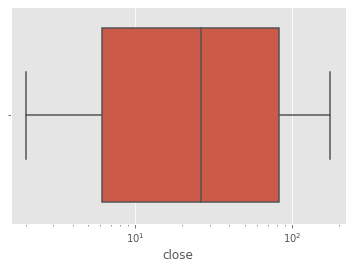

In [132]:
sns.boxplot("close", data=stock_agg)
plt.xscale("log")

In [133]:
len(stock_agg[stock_agg.close>Q3['close']+1.5*IQR[0]]) * 100/len(stock_agg)

0.0

In [134]:
len(stock_agg[stock_agg.close<Q1['close']-1.5*IQR[0]]) * 100/len(stock_agg)

0.0

Around 75 is the IQR for closing price. None of the values are more than the 1.5*IQR range.

c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


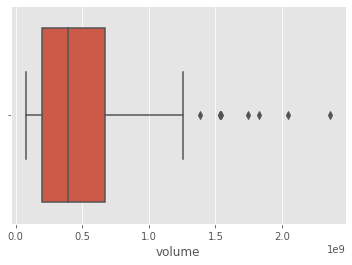

In [135]:
sns.boxplot("volume", data=stock_agg)


In [136]:
len(stock_agg[stock_agg.volume>Q3['volume'] + 1.5*IQR[1]]) * 100/len(stock_agg)

3.8461538461538463

In [137]:
stock_agg = stock_agg[stock_agg.volume < stock_agg.volume.quantile(.95)]

c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


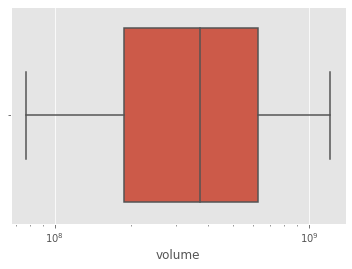

In [138]:
sns.boxplot("volume", data=stock_agg)
plt.xscale("log")

In [139]:
len(stock_agg[stock_agg.volume>Q3['volume'] + 1.5*IQR[1]]) * 100/len(stock_agg)

0.0

## Creating the features and independent variable

In [140]:
stock_agg.head()

,year,month,close,volume,yrmo,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_ 3,rsi_3,ma_ 6,rsi_6,ma_ 9,rsi_9,ma_ 12,rsi_12
11,2000,12,2.437143,276921400,200012,3.178571,3.170000,9.062857,6.768571,7.777143,13.222857,1.201641,14.738265,2.215318,19.702538,3.674547,20.934933,4.399326,28.212687
12,2001,1,2.338571,302642200,20011,2.437143,3.178571,3.170000,9.062857,6.768571,7.777143,1.133781,14.357978,1.921095,19.541769,3.046291,20.833461,4.156791,28.097229
13,2001,2,2.945714,384461700,20012,2.338571,2.437143,3.178571,3.170000,9.062857,6.768571,0.873747,30.844316,1.308843,24.118311,1.919981,23.405988,2.946896,30.021524
14,2001,3,2.750000,224981400,20013,2.945714,2.338571,2.437143,3.178571,3.170000,9.062857,0.973853,28.217782,1.019394,23.599064,1.633478,23.133378,2.685844,29.741619
15,2001,4,2.941429,270841900,20014,2.750000,2.945714,2.338571,2.437143,3.178571,3.170000,0.978792,36.189885,0.940100,25.482080,1.344504,24.106032,2.061154,30.433688


Right now we have derived various features from the dataset but we haven't augmented it with outside knowledge. Let's include one more feature which is whether that particular month had a special **Apple Event** or not.

In [141]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\rahel\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


In [142]:
pip install requests

You should consider upgrading via the 'c:\users\rahel\appdata\local\programs\python\python36\python.exe -m pip install --upgrade pip' command.


In [143]:
import requests, bs4

In [144]:
req = requests.get("https://en.wikipedia.org/wiki/List_of_Apple_Inc._media_events")
soup = bs4.BeautifulSoup(req.text, "html.parser")
spans = soup.find_all('span', attrs={'class':'toctext'})
for span in spans[0:5]:
    print(span.text)

Venues
2005
WWDC 2005 (June 6–10, 2005)
2006
Apple Special Event (February 28, 2006)


In [145]:
import calendar
months = list(calendar.month_name)[1:]

In [146]:
events = []
for span in spans:
    stxt = span.text
    for i, month in enumerate(months):
        if month in stxt:
            yr = stxt[-5:-1]
            events.append(yr+str(i+1))
print(events)

['20056', '20062', '20068', '20069', '20071', '20086', '20096', '20101', '20104', '20106', '20109', '20113', '20116', '201110', '20123', '20126', '20129', '201210', '20136', '20139', '201310', '20146', '20149', '201410', '20153', '20156', '20159', '20163', '20166', '20169', '201610', '20176', '20179', '20183', '20186', '20189', '201810', '20193', '20196', '20199', '201912', '20206', '20209', '202010']


So we have all the events let's merge it with our dataframe

In [147]:
stock_agg['event'] = stock_agg['yrmo'].apply(lambda ymo : 1 if ymo in events else 0)
stock_agg[['yrmo','event']].tail(7)

,yrmo,event
212,20179,1
213,201710,0
214,201711,0
215,201712,0
216,20181,0
217,20182,0
218,20183,1


c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel den

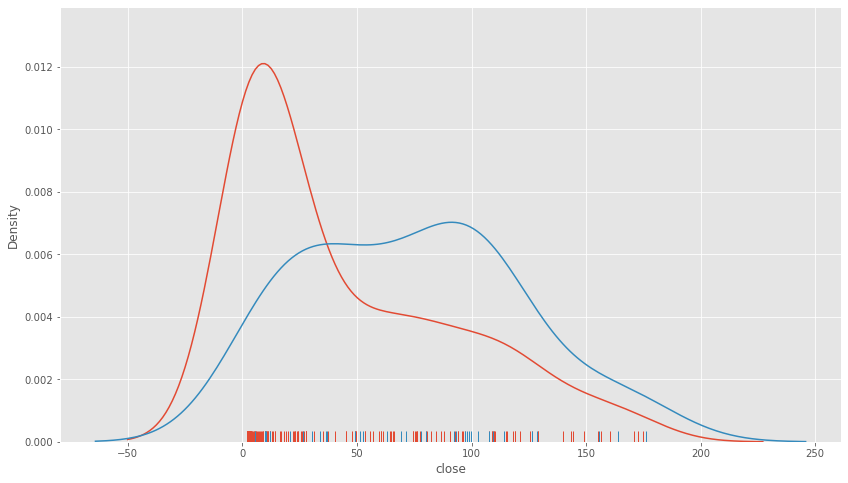

In [148]:
plt.figure(figsize=(14,8))
sns.distplot(stock_agg.loc[stock_agg.event==0,'close'], hist=False, rug=True,label='No Events')
sns.distplot(stock_agg.loc[stock_agg.event==1,'close'], hist=False, rug=True, label='Events')
plt.show()

In [149]:
print("Event Mean ",stock_agg.loc[stock_agg.event==1,:]['close'].mean())
print("Non Event Mean ",stock_agg.loc[stock_agg.event==0,:]['close'].mean())

Event Mean  73.85152521008403
Non Event Mean  44.80273523225241


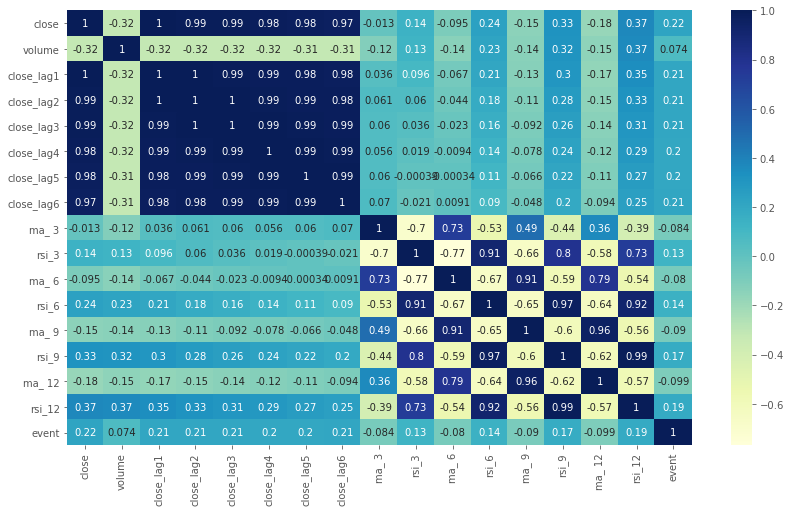

In [150]:
plt.figure(figsize=(14,8))
corr = stock_agg.drop(columns=["year","month","yrmo"]).corr()
sns.heatmap(data=corr, annot=True, cmap="YlGnBu")

So we do see a positive correlation between the events and closing price, so this could be a driver variable.

##### We are trying to predict the closing price so it will become our independent variable.

# Prepare The Data For Modelling

Dropping **time** columns as they do not have significance as a driver for closing price.

In [151]:
stock_final = stock_agg.drop(columns = ["year","month","yrmo"], axis = 1)

In [152]:
stock_final.head()

,close,volume,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_ 3,rsi_3,ma_ 6,rsi_6,ma_ 9,rsi_9,ma_ 12,rsi_12,event
11,2.437143,276921400,3.178571,3.170000,9.062857,6.768571,7.777143,13.222857,1.201641,14.738265,2.215318,19.702538,3.674547,20.934933,4.399326,28.212687,0
12,2.338571,302642200,2.437143,3.178571,3.170000,9.062857,6.768571,7.777143,1.133781,14.357978,1.921095,19.541769,3.046291,20.833461,4.156791,28.097229,0
13,2.945714,384461700,2.338571,2.437143,3.178571,3.170000,9.062857,6.768571,0.873747,30.844316,1.308843,24.118311,1.919981,23.405988,2.946896,30.021524,0
14,2.750000,224981400,2.945714,2.338571,2.437143,3.178571,3.170000,9.062857,0.973853,28.217782,1.019394,23.599064,1.633478,23.133378,2.685844,29.741619,0
15,2.941429,270841900,2.750000,2.945714,2.338571,2.437143,3.178571,3.170000,0.978792,36.189885,0.940100,25.482080,1.344504,24.106032,2.061154,30.433688,0


## Normalize the data

In [153]:
stock_n = stock_final.loc[:, stock_final.columns != 'close']

In [154]:
stock_n = (stock_n - stock_n.mean()) / stock_n.std()

In [155]:
stock_m = pd.concat([stock_n,stock_final.loc[:,'close']],axis=1)

In [156]:
stock_m.head()

,volume,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_ 3,rsi_3,ma_ 6,rsi_6,ma_ 9,rsi_9,ma_ 12,rsi_12,event,close
11,-0.556352,-0.943757,-0.936111,-0.808105,-0.853636,-0.830550,-0.706164,2.600233,-1.853923,6.935010,-2.008533,8.688322,-2.057595,7.796089,-1.903379,-0.455555,2.437143
12,-0.470006,-0.959075,-0.935932,-0.933197,-0.804119,-0.852725,-0.827647,1.795119,-1.868077,5.293320,-2.016073,6.664552,-2.062874,7.241775,-1.910311,-0.455555,2.338571
13,-0.195332,-0.961112,-0.951415,-0.933015,-0.931303,-0.802282,-0.850146,-1.290019,-1.254463,1.877102,-1.801442,3.036429,-1.929036,4.476557,-1.794767,-0.455555,2.945714
14,-0.730718,-0.948568,-0.953474,-0.948754,-0.931118,-0.931846,-0.798965,-0.102330,-1.352221,0.262051,-1.825794,2.113532,-1.943219,3.879922,-1.811574,-0.455555,2.750000
15,-0.576761,-0.952612,-0.940795,-0.950846,-0.947121,-0.931657,-0.930422,-0.043726,-1.055503,-0.180387,-1.737484,1.182676,-1.892616,2.452192,-1.770019,-0.455555,2.941429


In [157]:
stock_m.to_csv("apple_stock_prepared.csv",index=False)

In [158]:
X = stock_m.loc[:, stock_m.columns != 'close']
Y = stock_m['close']

In [159]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [160]:
print("Length Of training data ", len(X_train))
print("Length Of test data ", len(X_test))
print("Length Of training Y ", len(Y_train))
print("Length Of test data Y", len(Y_test))

Length Of training data  157
Length Of test data  40
Length Of training Y  157
Length Of test data Y 40


So we have made our data ready for training. The only thing that is left is to plug in this data through a model for prediction which we will see in subsequent sections.

# Linear regression model

In [161]:
def linear_reg(Y_train, X_train, isSummary=False):

    # Add a bias column to the training dataset before fitting the model
    X_train = sm.tools.tools.add_constant(X_train, has_constant='add')
    lm_1 = OLS(Y_train,X_train).fit()
    
    if isSummary:
        #Visualise the results of the model
        print(lm_1.summary())
    return lm_1

In [163]:
mod = linear_reg(Y_train, X_train, isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2019.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          6.57e-157
Time:                        17:02:29   Log-Likelihood:                -408.85
No. Observations:                 157   AIC:                             851.7
Df Residuals:                     140   BIC:                             903.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0166      0.279    179.169      0.0

In [164]:
def vif_cal(input_df):
    """
    Calculates VIF for the dependent variables

    """
    vif_df = pd.DataFrame(columns = [ 'Var', 'Vif']);
    i=0
    for var in input_df:
        y_vars = input_df[var]
        x_vars = input_df.drop(var, inplace=False, axis=1)
        r2s = OLS(y_vars, x_vars).fit().rsquared
        vif = round(1/(1-r2s),2)
        vif_df.loc[i] = [var,vif]
        i+=1
    return vif_df.sort_values(by = 'Vif', ascending = False, inplace = False)

In [165]:
vif_cal( X_train)

,Var,Vif
12,rsi_9,730.78
10,rsi_6,328.26
2,close_lag2,238.48
14,rsi_12,226.72
5,close_lag5,224.08
3,close_lag3,207.94
4,close_lag4,205.87
6,close_lag6,144.63
1,close_lag1,130.36
11,ma_ 9,80.83


In [166]:
X_t_1 = X_train.drop(columns=["rsi_9", "rsi_6", "close_lag2", "rsi_12", "close_lag5", "close_lag3", "close_lag4" ],axis=1)

In [167]:
linear_reg(Y_train,X_t_1,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3130.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          3.81e-163
Time:                        17:02:35   Log-Likelihood:                -423.37
No. Observations:                 157   AIC:                             866.7
Df Residuals:                     147   BIC:                             897.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0166      0.297    168.360      0.0

In [168]:
vif_cal( X_t_1)

,Var,Vif
6,ma_ 9,70.85
1,close_lag1,36.15
2,close_lag6,35.34
7,ma_ 12,28.92
5,ma_ 6,27.75
3,ma_ 3,3.96
4,rsi_3,3.86
0,volume,1.21
8,event,1.08


In [169]:
X_t_2 = X_t_1.drop(columns=["ma_ 9", "close_lag1" ],axis=1)

In [170]:
linear_reg(Y_train,X_t_2,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     799.2
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          1.00e-114
Time:                        17:02:35   Log-Likelihood:                -549.66
No. Observations:                 157   AIC:                             1115.
Df Residuals:                     149   BIC:                             1140.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0474      0.658     76.005      0.0

In [171]:
vif_cal( X_t_2)

,Var,Vif
4,ma_ 6,7.31
5,ma_ 12,3.92
2,ma_ 3,3.18
3,rsi_3,2.68
1,close_lag6,1.23
0,volume,1.16
6,event,1.08


In [172]:
X_t_3 = X_t_2.drop(columns=["ma_ 3"],axis=1)

In [173]:
linear_reg(Y_train,X_t_3,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     895.5
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          9.68e-115
Time:                        17:02:35   Log-Likelihood:                -553.26
No. Observations:                 157   AIC:                             1121.
Df Residuals:                     150   BIC:                             1142.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0268      0.671     74.508      0.0

In [174]:
vif_cal( X_t_3)

,Var,Vif
3,ma_ 6,4.29
4,ma_ 12,2.85
2,rsi_3,2.44
1,close_lag6,1.22
0,volume,1.16
5,event,1.08


In [175]:
X_t_4 = X_t_3.drop(columns=["ma_ 12", "event"],axis=1)

In [176]:
linear_reg(Y_train,X_t_4,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1344.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          1.80e-117
Time:                        17:04:01   Log-Likelihood:                -554.22
No. Observations:                 157   AIC:                             1118.
Df Residuals:                     152   BIC:                             1134.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9902      0.670     74.575      0.0

In [177]:
vif_cal( X_t_4)

,Var,Vif
3,ma_ 6,2.41
2,rsi_3,2.40
0,volume,1.12
1,close_lag6,1.11


In [188]:
X_t_5 = X_t_4.drop(columns=["ma_ 6", "volume"],axis=1)

In [189]:
model=linear_reg(Y_train,X_t_5,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2595.
Date:                Thu, 29 Oct 2020   Prob (F-statistic):          2.50e-119
Time:                        22:12:18   Log-Likelihood:                -557.92
No. Observations:                 157   AIC:                             1122.
Df Residuals:                     154   BIC:                             1131.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0579      0.681     73.466      0.0

In [180]:
vif_cal( X_t_5)

,Var,Vif
0,close_lag6,1.0
1,rsi_3,1.0


# Performance On Test Data

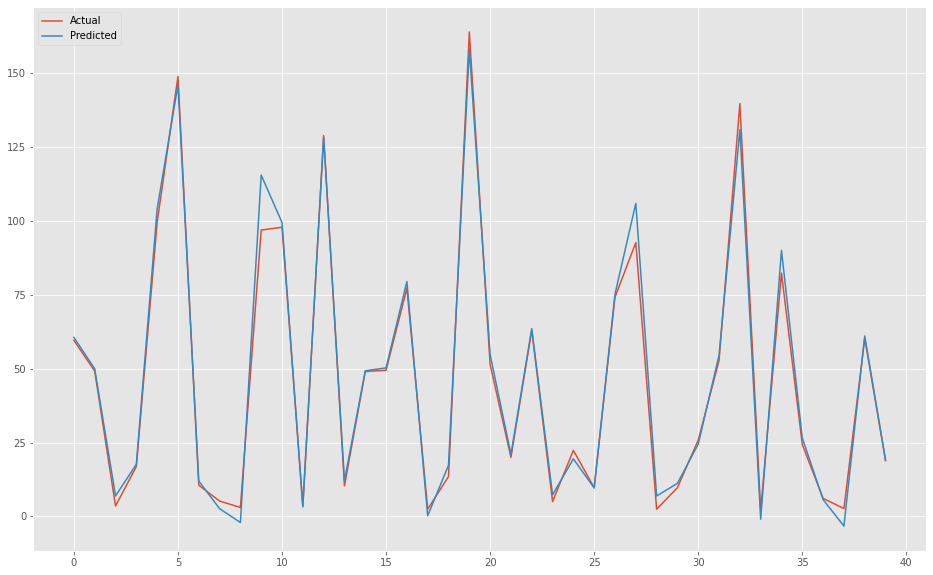

In [181]:
X_test = sm.tools.tools.add_constant(X_test, has_constant='add')
Y_test_p = mod.predict(X_test)

plt.figure(figsize=(16,10))
plt.plot(range(0,len(Y_test)),Y_test, label='Actual')
plt.plot(range(0,len(Y_test)),Y_test_p, label='Predicted')
plt.legend(loc='upper left')

In [182]:
r2_score(Y_test, Y_test_p)

0.9889995720911667

In [183]:
error = Y_test - Y_test_p

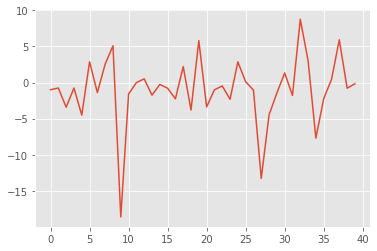

In [184]:
plt.plot(range(0,len(Y_test)),error)

c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


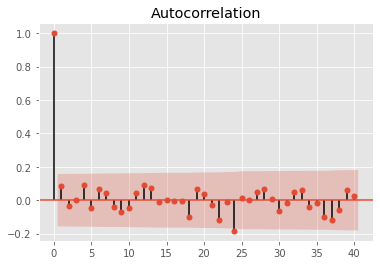

In [190]:
acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
acf.show()

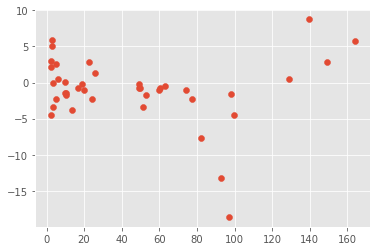

In [191]:
plt.scatter(Y_test,error)